# CSE 144 Fall 2023 HW 1

In this assignment, the goal is to build a linear regression model to predict the song popularity based on energy, acoustics, instumentalness, liveness, dancibility, etc. We'll be using the [Song Popularity Dataset](https://www.kaggle.com/datasets/yasserh/song-popularity-dataset) dataset from Kaggle dataset.

In the first section, you'll perform standard data preprocessing using techniques we covered in class, including binning, one-hot encoding, feature crossing, and normalization. In the second section, you'll train a simple linear regression model to predict the song popularity

## Instruction 

- Submit your assignments onto **Canvas** by the due date.
- This is an **individual** assignment. All help from others (from the web, books other than text, or people other than the TA or instructor) must be clearly acknowledged. 
- Don't change the input and output structure of pre-defined functions. Most coding parts can be finished with about 5-6 lines of codes. 
- You should be able to use NumPy, Pandas, and the `train_test_split()` function from scikit-learn to complete everything in this assignment. We also imported Matplotlib for you to visualize the training and validation loss.
- Remember that tuning on the test loss is prohibited.

## Rubric

The assignment is worth 50 (47+3) points in total:
- Data preprocessing (12 points)
    - drop missing values (2 points)
    - drop outliers (5 points)
    - normalization (5 points)
- Dataset split (10 points)
    - test set split (5 points)
    - k-fold train and validation set split (5 points)
- Linear regression (25 points)
    - MSE_loss (3 points)
    - Gradient (5 points)
    - Theta initialization (3 points)
    - Translate dataframe to numpy (3 points)
    - Traininig (5 points)
        - Save train and val loss (2 points)
        - Update parameters (3 points)
    - Find best parameters (3 points)
    - Evaluate on test set (3 points)

- Bonus (3 points)
    - If your test loss is below 0.025

In [27]:
!python3 --version

Python 3.11.4


In [28]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
seed = 144
random.seed(seed)
np.random.seed(seed)

print(seed)

144


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


array([[<AxesSubplot: title={'center': 'song_popularity'}>,
        <AxesSubplot: title={'center': 'song_duration_ms'}>,
        <AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'danceability'}>],
       [<AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'key'}>,
        <AxesSubplot: title={'center': 'liveness'}>],
       [<AxesSubplot: title={'center': 'loudness'}>,
        <AxesSubplot: title={'center': 'audio_mode'}>,
        <AxesSubplot: title={'center': 'speechiness'}>,
        <AxesSubplot: title={'center': 'tempo'}>],
       [<AxesSubplot: title={'center': 'time_signature'}>,
        <AxesSubplot: title={'center': 'audio_valence'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

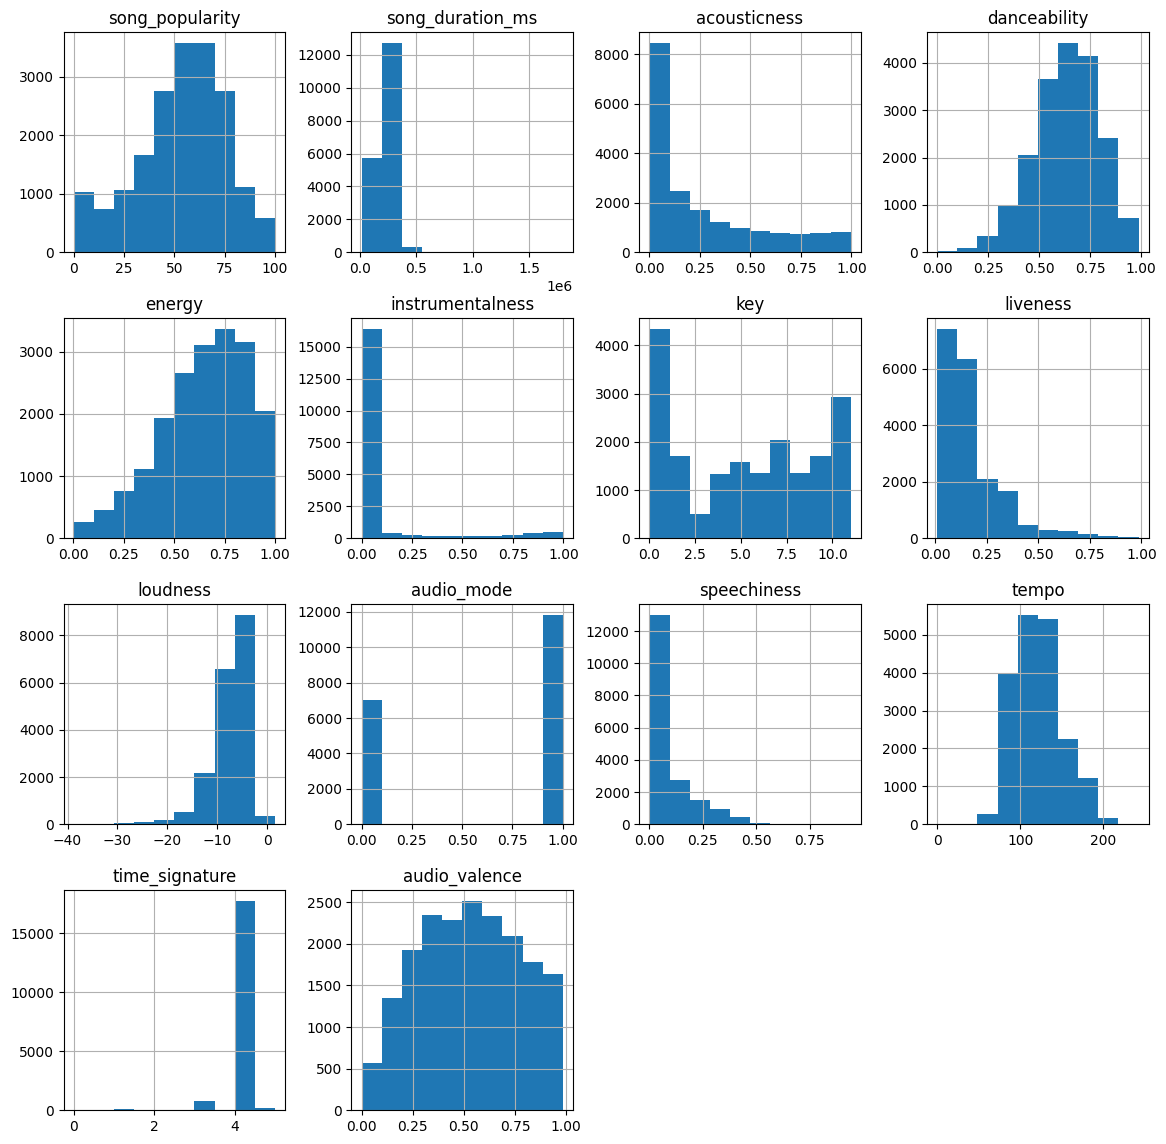

In [29]:
# Load data
data = pd.read_csv("./song_data.csv").drop(["song_name"], axis = 1)

# Visualize data
df = pd.DataFrame(data)
df.info()
df.hist(figsize=(14,14))


### Data Cleaning
`data.info()` shows that there are some missing values in the dataset. Also, we can see from the histogram that outliers exist for some features. Moreover, the range of different features has a huge gap: most in (0,1), but some are on the order of 1e2, or even 1e5. In the following you need to perform:
1. Drop rows that contain NULL values.
2. Remove outliers for features in ['song_duration_ms', 'instrumentalness'] based on interquantile range.
3. Scale ranges of independent variables using Z-score method, and normalize the range of dependent feature ['song_popularity'] from [0,100] to [0,1]

In [30]:
# drop rows that have NULL value
# ========== YOUR CODE STARTS HERE ==========
# used this resources: https://saturncloud.io/blog/how-to-delete-rows-with-null-values-in-a-specific-column-in-pandas-dataframe/#:~:text=Deleting%20rows%20with%20null%20values%20in%20a%20specific%20column%20can,()%20method%20of%20Pandas%20DataFrame.

for subset in df.columns:
    sub_df = pd.DataFrame(df[subset])
    if sub_df.isnull().any().any():
        sub_df = sub_df.dropna()
        df[subset] = sub_df
        
print(df)


if df.isna().any().any():
    print('Nan Value found')

# ========== YOUR CODE ENDS HERE ============

'''
Remove outliers for features in ['song_duration_ms', 'instrumentalness', 'time_signature'] 
based on interquantile range. Here for each feature, we first sort data in an ascending order.
Let q1 and q3 be the data that ranks 25% and 75% respectively. We then let iqr = q3 - q1, and 
compute 
                a = q1 - iqr x 1.5,
                b = q3 + iqr x 1.5,
and remove the data out of the range [a, b].
Note: this can be realized with function quantile().
'''

for feature in ['song_duration_ms', 'instrumentalness']:
    # ========== YOUR CODE STARTS HERE ==========
    # Calculate the first quartile (Q1) and third quartile (Q3)
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    df = df[df[feature] <= (Q3+(1.5*IQR))]
    df = df[df[feature] >= (Q1-(1.5*IQR))]
    # Q1 = df[feature].quantile(0.25)
    # Q3 = df[feature].quantile(0.75)
    # 
    # # Calculate the interquartile range (IQR)
    # IQR = Q3 - Q1
    # 
    # # Determine the lower and upper bounds for outlier detection
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR
    # 
    # # Remove outliers based on the calculated bounds
    # df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    # ========== YOUR CODE ENDS HERE ============
    
df = df.reset_index(drop=True)
print('here is data cleaned\n', df)


'''
Scale all features using z-score normalization. 
Note: use different column and std for different columns!
'''
# ========== YOUR CODE STARTS HERE ==========
#  I used this resource I found during how to use the zscore formula: https://datagy.io/python-z-score/
# import scipy.stats as stats

z_scores = df.apply(lambda x: (x - x.mean()) / x.std())
# print('here are z scores\n', z_scores)

data = z_scores
# ========== YOUR CODE ENDS HERE ============

       song_popularity  song_duration_ms  acousticness  danceability  energy  \
0                   73            262333      0.005520         0.496   0.682   
1                   66            216933      0.010300         0.542   0.853   
2                   76            231733      0.008170         0.737   0.463   
3                   74            216933      0.026400         0.451   0.970   
4                   56            223826      0.000954         0.447   0.766   
...                ...               ...           ...           ...     ...   
18830               60            159645      0.893000         0.500   0.151   
18831               60            205666      0.765000         0.495   0.161   
18832               23            182211      0.847000         0.719   0.325   
18833               55            352280      0.945000         0.488   0.326   
18834               60            193533      0.911000         0.640   0.381   

       instrumentalness  key  liveness 

Now we visualize the data again.

0       -0.307712
1       -0.351959
2        4.990786
3       -0.351959
4       -0.349175
           ...   
14138   -0.351959
14139   -0.253532
14140   -0.349958
14141   -0.351959
14142    0.030310
Name: instrumentalness, Length: 14143, dtype: float64
0        0.117819
1        0.117819
2        0.117819
3        0.117819
4        0.117819
           ...   
14138    0.117819
14139    0.117819
14140    0.117819
14141    0.117819
14142    0.117819
Name: time_signature, Length: 14143, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14143 entries, 0 to 14142
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   14143 non-null  float64
 1   song_duration_ms  14143 non-null  float64
 2   acousticness      14143 non-null  float64
 3   danceability      14143 non-null  float64
 4   energy            14143 non-null  float64
 5   instrumentalness  14143 non-null  float64
 6   key     

array([[<AxesSubplot: title={'center': 'song_popularity'}>,
        <AxesSubplot: title={'center': 'song_duration_ms'}>,
        <AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'danceability'}>],
       [<AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'key'}>,
        <AxesSubplot: title={'center': 'liveness'}>],
       [<AxesSubplot: title={'center': 'loudness'}>,
        <AxesSubplot: title={'center': 'audio_mode'}>,
        <AxesSubplot: title={'center': 'speechiness'}>,
        <AxesSubplot: title={'center': 'tempo'}>],
       [<AxesSubplot: title={'center': 'time_signature'}>,
        <AxesSubplot: title={'center': 'audio_valence'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

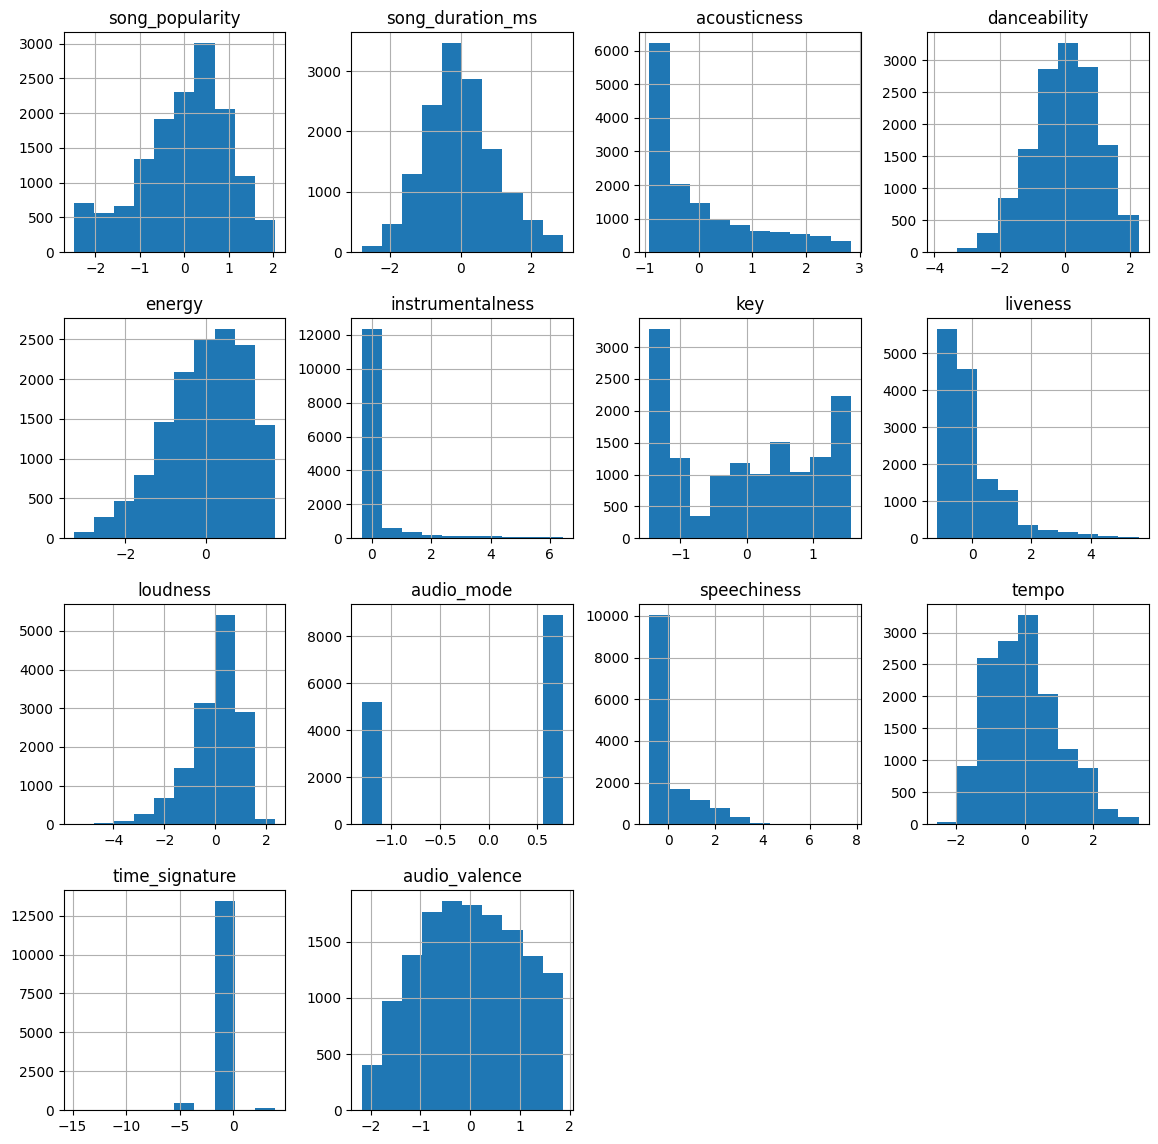

In [31]:
print(data['instrumentalness'])
print(data['time_signature'])

data.info()
data.hist(figsize=(14,14))

## Dataset preparation
Next we will split dataset to train set, validation set and test set. First we randomly choose 30% as test set. Then we use $k$-fold validation on the remaining 70% to generate $k$ different train set and validation set pairs, where $k=5$.

In [39]:
def test_split(data, test_size: float=0.3, seed=seed):
    """
    Use function train_test_split() to split test set.
    """
    # ========== YOUR CODE STARTS HERE ==========
    X = (data.drop(labels=['song_popularity'], axis=1)).to_numpy()
    y = data.song_popularity.to_numpy()
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    X_train_val = pd.DataFrame(X_train_val)
    y_train_val = pd.DataFrame(y_train_val) 
    X_test = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test)
    
    print(X_train_val.reset_index(drop=True),
            y_train_val.reset_index(drop=True),
            X_test.reset_index(drop=True),
            y_test.reset_index(drop=True))

    # ========== YOUR CODE ENDS HERE ============
    
    return (X_train_val.reset_index(drop=True),
            y_train_val.reset_index(drop=True),
            X_test.reset_index(drop=True),
            y_test.reset_index(drop=True))
    

def train_val_split(X_train_val, y_train_val, k=5, seed=seed):
    """
    Use given index sets to generate k train and validation pairs. The return value should be 
    a list whose components are tuples:
    [(X_train1, y_train1, X_val1, y_val1), ..., (X_traink, y_traink, X_valk, y_valk)]
    
    Here suppose data length is 10, the index sets could be like:
                    [[2,5], [1,6], [3,8], [9,4], [0,7]]
    
    """
    index_shuffle = list(X_train_val.index)
    random.shuffle(index_shuffle)
    index_split_list = [[index_shuffle[i+j] for i in range(0, len(index_shuffle), 5)  if i+j<len(index_shuffle)] for j in range(5)]
    train_val_pairs = [0 for i in range(k)]
    # ========== YOUR CODE STARTS HERE ==========
    for fold in range(k):
        val_idx = index_split_list[fold]
        train_idx = [idx for split in index_split_list[:fold] + index_split_list[fold + 1:] for idx in split]
        
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        
        train_val_pairs.append((X_train, y_train, X_val, y_val))
        
    # ========== YOUR CODE ENDS HERE ============    
    return train_val_pairs

X_train_val, y_train_val, X_test, y_test = test_split(data)
train_val_pairs = train_val_split(X_train_val, y_train_val)

            0         1         2         3         4         5         6   \
0    -0.563880 -0.685288  0.012671  1.000741 -0.351959  0.741013 -0.828285   
1    -0.258467 -0.467386 -1.013488  0.785544 -0.351959  0.464965 -0.226679   
2     0.989530 -0.562884  2.058283  0.227056 -0.351959 -0.915273 -0.324615   
3    -1.022987 -0.474965  1.253452  0.206561 -0.351959 -0.087130 -0.471519   
4    -0.089323 -0.482544  0.535811  1.446507  6.134585 -0.087130 -0.657597   
...        ...       ...       ...       ...       ...       ...       ...   
9895  0.680973 -0.879695  0.737019  1.359403  6.074385  1.017061 -0.240670   
9896 -0.424101  0.578545  1.072365  1.159577 -0.351959 -0.915273 -0.723354   
9897 -0.509806  0.354958 -1.382369  1.467002 -0.351959  0.188918 -0.637310   
9898 -1.844750 -0.715984  0.696777 -1.094870 -0.344194 -0.363177 -0.457528   
9899 -0.664621 -0.917515 -0.812281  1.441383 -0.351959  1.017061  3.096144   

            7         8         9         10        11        1

## Linear regression

Hint: A convenient way to calculate $X \cdot \theta$ is to prepend a column of 1's to your $X$ matrix so that you don't have to perform an extra addition operation. If you used this implementation, please also add an additional dimension to your feature matrix so that they are consistent in shape. See the image below for illustration. See this [illustration](https://cs231n.github.io/linear-classify/#:~:text=Illustration%20of%20the,and%20the%20biases.) for more detail.

In [41]:
from sklearn.metrics import accuracy_score


def MSE_loss(pred: np.ndarray, target: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    loss = np.mean((pred - target)**2)
    return loss
    # ========== YOUR CODE ENDS HERE ============ 

def gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    X = np.hstack([np.ones((X.shape[0],1)), X]) 
    predictions = X.dot(theta)
    error = predictions - y
    gradient = 1/len(X) * X.T.dot(error)
    return gradient
    # ========== YOUR CODE ENDS HERE ============ 


num_epochs = 5000
learning_rate = 1e-3
k = 5
train_loss_history = [[] for _ in range(k)]
val_loss_history = [[] for _ in range(k)]

theta_min = None
index_min = None
loss_min = None

for i in range(k):
    X_train, y_train, X_val, y_val = train_val_pairs[i]
    
    # Translate dataframe to numpy     
    # ========== YOUR CODE STARTS HERE ==========
    train_val_pairs.append((X_train, y_train, X_val, y_val))
    X_train = X_train.values
    y_train = y_train.values

    X_val = X_val.values
    y_val = y_val.values
    # ========== YOUR CODE ENDS HERE ============
    
    # Initialize theta    
    # ========== YOUR CODE STARTS HERE ==========
    theta = np.random.randn(X_train.shape[1])
    # ========== YOUR CODE ENDS HERE ============
    
    for epoch in range(num_epochs):
        # Compute loss, and save to train_loss_history and val_loss_history
        # ========== YOUR CODE STARTS HERE ==========
        train_loss = MSE_loss(X_train, y_train)
        train_loss_history[i].append(train_loss)

        val_loss = MSE_loss(X_val, y_val, theta)
        val_loss_history[i].append(val_loss)
        # ========== YOUR CODE ENDS HERE ============
        
        # Update parameter
        # ========== YOUR CODE STARTS HERE ==========
        grad = gradient(X_train, y_train, theta)
        theta = theta - learning_rate * grad
        # ========== YOUR CODE ENDS HERE ============

    
    # Inference on validation set, and fine the best parameters. Save corresponding parameters and index in theta_min and  index_min
    # ========== YOUR CODE STARTS HERE ==========
    if loss_min is None or val_loss < loss_min:
        theta_min = theta
        loss_min = val_loss
        index_min = i
    # ========== YOUR CODE ENDS HERE ============


print(f"Final train loss for the best model: {train_loss_history[index_min][-1]}")
print(f"Final validation loss for the best model: {val_loss_history[index_min][-1]}")
print(theta_min)

plt.plot(np.arange(num_epochs), train_loss_history[index_min], label="Train loss")
plt.plot(np.arange(num_epochs), val_loss_history[index_min], label="Val loss")
plt.title("Train + validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Evaluate on test set
# ========== YOUR CODE STARTS HERE ==========
best_theta = theta_min

# Translate test set to numpy
X_test = X_test.values
y_test = y_test.values

# Make predictions on test set
y_pred = X_test.dot(best_theta)

# Evaluate predictions
test_loss = MSE_loss(y_pred, y_test) 
test_accuracy = accuracy_score(y_pred, y_test)
# ========== YOUR CODE ENDS HERE ============                  
print(f"Test loss: {test_loss}")

TypeError: cannot unpack non-iterable int object